In [0]:
%tensorflow_version 1.x
import pickle
import os,cv2
import numpy as np
import skimage.io
import matplotlib.pyplot as plt
from skimage import transform,exposure
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras.utils import to_categorical
from keras.layers import Dense,Dropout,Conv2D,MaxPooling2D,ReLU,Flatten,BatchNormalization,Activation
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow

TensorFlow is already loaded. Please restart the runtime to change versions.


In [0]:
!ls

adc.json      G_Test   GTSRB_Final_Test_Images.zip	sample_data
download.png  G_Train  GTSRB_Final_Training_Images.zip	stop.jpg


In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
#1EgzS-nwB4ECOpgf_nzS2lMGj4ogLKVK0 Training
#1QFMZWwc0iYyVWFLzMM7DJF3W6DZqEdE9 Testing
#https://drive.google.com/open?id=1HquTQTRbiqu04S0v_kVAbdr10msBZ_Vx TRAIN
#https://drive.google.com/open?id=1BLFxvwMwxZBeb3ir93OUpZbYKYiddgDD TEST
# downloaded_train = drive.CreateFile({'id':"1EgzS-nwB4ECOpgf_nzS2lMGj4ogLKVK0"})   # replace the id with id of file you want to access
# downloaded_train.GetContentFile('BelgiumTSC_Training.zip')    
# downloaded_test = drive.CreateFile({'id':"1QFMZWwc0iYyVWFLzMM7DJF3W6DZqEdE9"})   # replace the id with id of file you want to access
# downloaded_test.GetContentFile('BelgiumTSC_Testing.zip')    
downloaded_train = drive.CreateFile({'id':"1HquTQTRbiqu04S0v_kVAbdr10msBZ_Vx"})
downloaded_train.GetContentFile('GTSRB_Final_Training_Images.zip')    
downloaded_test=drive.CreateFile({'id':"1BLFxvwMwxZBeb3ir93OUpZbYKYiddgDD"})
downloaded_test.GetContentFile('GTSRB_Final_Test_Images.zip')

In [0]:
# !mkdir G_Train
# !mkdir G_Test
!unzip -qq GTSRB_Final_Training_Images.zip -d G_Train
!unzip -qq GTSRB_Final_Test_Images.zip -d G_Test

In [0]:
pre = ['20 km/h', '30 km/h', '50 km/h', '60 km/h', '70 km/h', '80 km/h', '80 km/h end', '100 km/h', '120 km/h', 'No overtaking',
               'No overtaking for tracks', 'Crossroad with secondary way', 'Main road', 'Give way', 'Stop', 'Road up', 'Road up for track', 'Brock',
               'Other dangerous', 'Turn left', 'Turn right', 'Winding road', 'Hollow road', 'Slippery road', 'Narrowing road', 'Roadwork', 'Traffic light',
               'Pedestrian', 'Children', 'Bike', 'Snow', 'Deer', 'End of the limits', 'Only right', 'Only left', 'Only straight', 'Only straight and right', 
               'Only straight and left', 'Take right', 'Take left', 'Circle crossroad', 'End of overtaking limit', 'End of overtaking limit for track']
def load_image(dir_path):
    all_dirs=[d for d in os.listdir(dir_path) if os.path.isdir(os.path.join(dir_path,d))]
    labels=[]
    images=[]

    for d in all_dirs:
        label_dir=os.path.join(dir_path,d)
        file_names=[os.path.join(label_dir,f) for f in os.listdir(label_dir) if f.endswith(".ppm")]
        for f in file_names:
            im=skimage.io.imread(f)
            img=cv2.resize(im,(64,64))
            images.append(img)
            labels.append(int(d))
    return images,labels
print(len(pre))

43


In [0]:
# ROOT_PATH=".\\traffic"
train_data_dir = os.path.join("G_Train/GTSRB/Final_Training/Images")
test_data_dir = os.path.join("G_Test/GTSRB/Final_Test/Images/")
images,labels=load_image(train_data_dir)
# timages,tlabels=load_image(test_data_dir)

In [0]:
class AlexNet:
  def build(self,no_of_classes):
    model=Sequential()
    model.add(Conv2D(96,kernel_size=11,strides=4,input_shape=(227,227,3)))
    model.add(ReLU())
    model.add(MaxPooling2D((3,3),strides=2))
    model.add(Conv2D(256,5,padding="same"))
    model.add(ReLU())
    model.add(MaxPooling2D((3,3),strides=2))
    model.add(Conv2D(384,3,padding="same"))
    model.add(ReLU())
    model.add(Conv2D(384,3,padding="same"))
    model.add(ReLU())
    model.add(Conv2D(256,3,padding="same"))
    model.add(ReLU())
    model.add(MaxPool2D((3,3),strides=2))
    model.add(Flatten())
    model.add(Dense(4096))
    model.add(Dense(4096))
    model.add(Dense(no_of_classes,activation="softmax"))
    return model

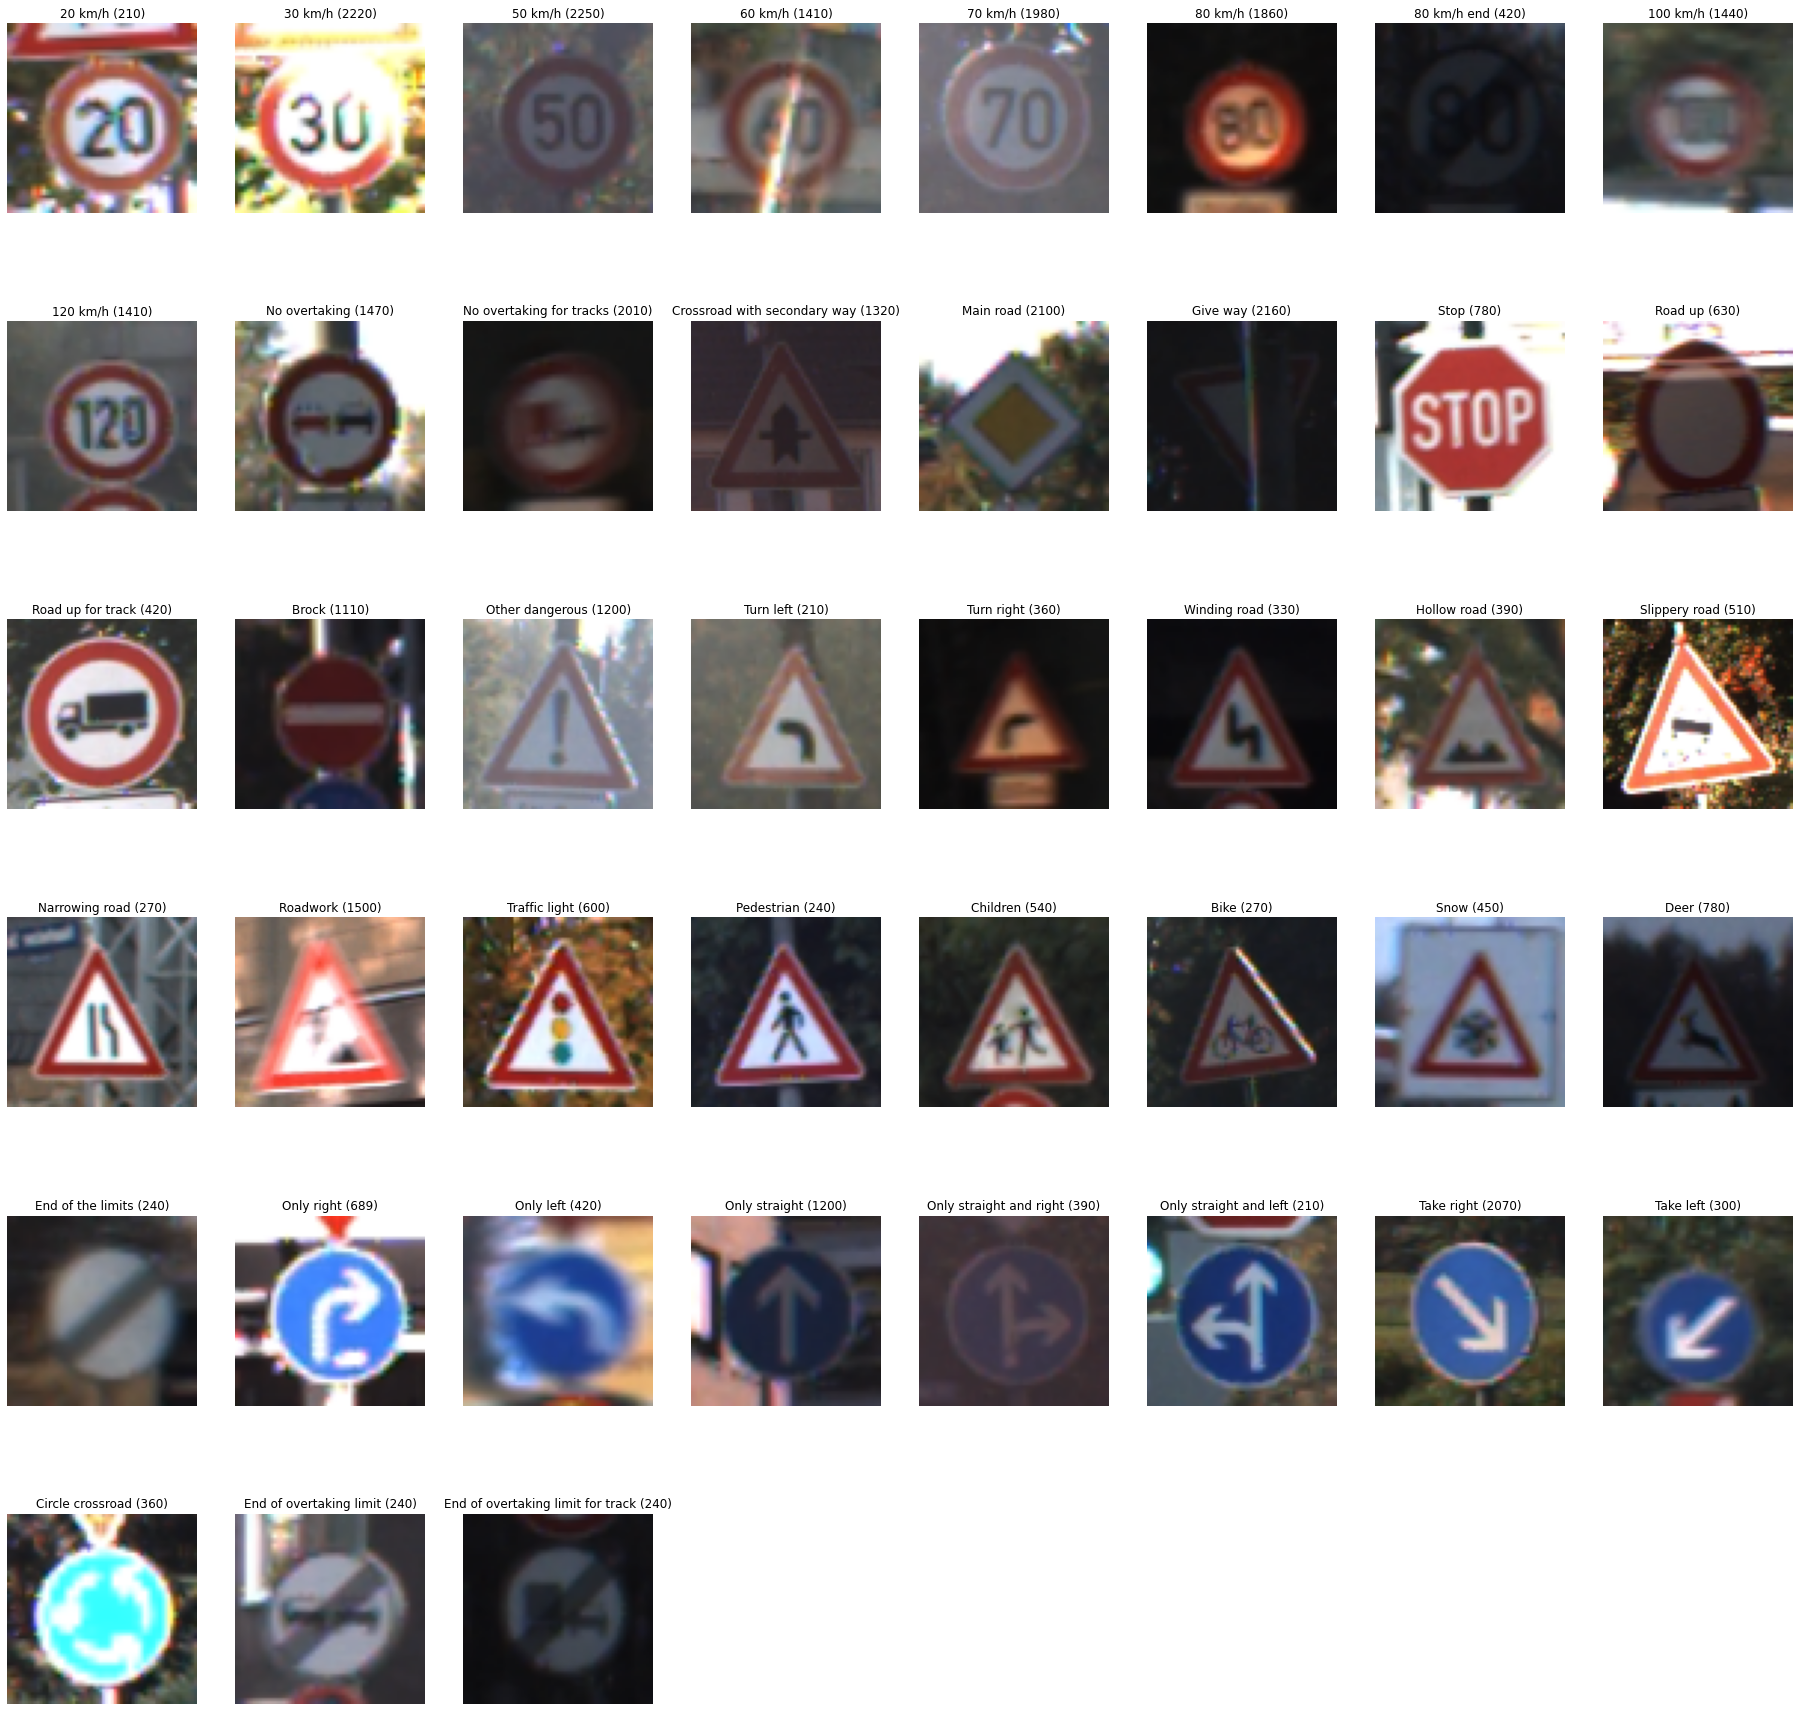

In [0]:
def display_images_and_labels(images, labels):
    unique_labels = set(labels)
    plt.figure(figsize=(32,32))
    i = 1
    for label in unique_labels:
        image = images[labels.index(label)]
        plt.subplot(6, 8, i)  
        plt.axis('off')
        plt.title("{0} ({1})".format(pre[label], labels.count(label)))
        i += 1
        _ = plt.imshow(image)
    plt.show()

display_images_and_labels(images, labels)

In [0]:
class TrafficNet:
  def build(self,height,width,depth,num_of_classes):
    input_shape=(height,width,depth)
    channel_dim=-1#TENSORFLOW (height,width,depth,channel)
    model=Sequential()
    model.add(Conv2D(8,3, padding="same", input_shape=input_shape))
    model.add(ReLU())
    model.add(BatchNormalization(axis=channel_dim))
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Conv2D(16, 3, padding="same"))
    model.add(ReLU())
    model.add(BatchNormalization(axis=channel_dim))
    model.add(Conv2D(16, 3, padding="same"))
    model.add(ReLU())
    model.add(BatchNormalization(axis=channel_dim))
    model.add(MaxPooling2D((2, 2)))
    
    # model.add(Conv2D(32,3, padding="same"))
    # model.add(ReLU())
    # model.add(BatchNormalization(axis=channel_dim))
    # model.add(Conv2D(32, 3, padding="same"))
    # model.add(ReLU())
    # model.add(BatchNormalization(axis=channel_dim))
    # model.add(MaxPooling2D((2, 2)))
    
    model.add(Flatten())
    model.add(Dense(128))
    model.add(ReLU())
    model.add(BatchNormalization())
    # model.add(Dropout(0.5))
    
    # model.add(Flatten())
    # model.add(Dense(128))
    # model.add(ReLU())
    # model.add(BatchNormalization())
    # model.add(Dropout(0.5))
    
    model.add(Dense(num_of_classes,activation="softmax"))

    return model

In [0]:

model=TrafficNet()
model=model.build(64,64,3,43)
model.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])


In [0]:

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 64, 64, 8)         224       
_________________________________________________________________
re_lu_9 (ReLU)               (None, 64, 64, 8)         0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 64, 64, 8)         32        
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 32, 32, 8)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 32, 32, 16)        1168      
_________________________________________________________________
re_lu_10 (ReLU)              (None, 32, 32, 16)        0         
_________________________________________________________________
batch_normalization_10 (Batc (None, 32, 32, 16)       

In [0]:
x_train,x_test,y_train,y_test=train_test_split(images,labels,test_size=0.2,random_state=4)
x_train=np.asarray(x_train)
y_train=np.asarray(y_train)
y_test=np.asarray(y_test)
y_test_not_categorical=y_test
y_train=to_categorical(y_train)
y_test=to_categorical(y_test)
print(y_test.shape)

(7842, 43)


In [0]:
model.fit(x_train,y_train,verbose=1,epochs=5,batch_size=300)

Epoch 1/5
31367/31367 [==============================] - 16s 494us/step - loss: 0.9886 - acc: 0.7551
Epoch 2/5
31367/31367 [==============================] - 14s 459us/step - loss: 0.1202 - acc: 0.9785
Epoch 3/5
31367/31367 [==============================] - 14s 452us/step - loss: 0.0419 - acc: 0.9949
Epoch 4/5
31367/31367 [==============================] - 14s 454us/step - loss: 0.0171 - acc: 0.9991
Epoch 5/5
31367/31367 [==============================] - 14s 454us/step - loss: 0.0083 - acc: 0.9998


In [0]:
x_test=np.asarray(x_test)
# y_test=to_categorical(y_test)

In [0]:
model.evaluate(x_test,y_test,verbose=2)


[0.047333572935612266, 0.9892884468247896]

In [0]:
y_pred=[]
for i in x_test:
  i=np.reshape(i,(1,64,64,3))
  a=np.argmax(model.predict(i)).to_categorical
  y_pred.append(a)
y_pred=np.asarray(y_pred)

NameError: ignored

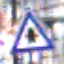

Crossroad with secondary way


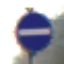

Brock


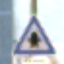

Crossroad with secondary way


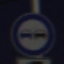

No overtaking


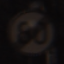

80 km/h end


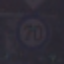

70 km/h


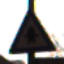

Crossroad with secondary way


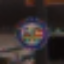

60 km/h


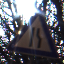

Narrowing road


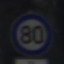

80 km/h


In [0]:
files = [os.path.join(test_data_dir,f) for f in os.listdir(test_data_dir) if f.endswith(".ppm")]
for i in range(10):
  img=skimage.io.imread(files[i])
  img=cv2.resize(img,(64,64))
  cv2_imshow(img)
  img=np.reshape(img,(1,64,64,3))
  params=np.argmax(model.predict(img))
  print(pre[params])

In [0]:
from sklearn.metrics import accuracy_score
mat = accuracy_score(y_test_not_categorical, y_pred)
# mat = confusion_matrix(y_test_not_categorical, y_pred)
print(mat)

0.9892884468247896


In [0]:
!ls
from google.colab import files
files=files.upload()

adc.json      G_Test   GTSRB_Final_Test_Images.zip	sample_data
download.png  G_Train  GTSRB_Final_Training_Images.zip	stop.jpg


Saving sn.png to sn.png


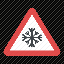

Slippery road


In [0]:
img=cv2.imread("sn.png")
img=cv2.resize(img,(64,64))
cv2_imshow(img)
img=np.reshape(img,(1,64,64,3))
params=np.argmax(model.predict(img))
print(pre[params])

In [0]:
import tensorflow as tf
import keras
keras_model_file="my_model.h5"
keras.models.save_model(model,keras_model_file)
converter = tf.lite.TFLiteConverter.from_keras_model_file(keras_model_file)
tflite_model = converter.convert()
open("converted_model.tflite", "wb").write(tflite_model)

from google.colab import files 
f=files.download("converted_model.tflite")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use `tf.compat.v1.graph_util.convert_variables_to_constants`
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`
INFO:tensorflow:Froze 26 variables.
INFO:tensorflow:Converted 26 variables to const ops.
